## Cats and Dog Classification

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

In [5]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
cats_folder = "kagglecatsanddogs_5340/PetImages"

animals = []
categories = ["Cat", "Dog"]

for category in categories:
    path = os.path.join(cats_folder, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        animals.append([img_path, categories.index(category)])

random.shuffle(animals)

In [7]:
data = pd.DataFrame(animals, columns=["image", "label"])
print(data.head())

                                            image  label
0   kagglecatsanddogs_5340/PetImages/Cat/8062.jpg      0
1   kagglecatsanddogs_5340/PetImages/Cat/2413.jpg      0
2  kagglecatsanddogs_5340/PetImages/Dog/10901.jpg      1
3   kagglecatsanddogs_5340/PetImages/Cat/9013.jpg      0
4   kagglecatsanddogs_5340/PetImages/Cat/5227.jpg      0


In [8]:
X,y = [],[]
for img, label in animals:
    try:
        img = load_img(img, target_size=(150,150))
        img = img_to_array(img)
        X.append(img)
        label = tf.keras.utils.to_categorical(label, num_classes=2)
        y.append(label)
    except:
        pass

/Users/rudrashah/anaconda3/envs/tensorflow/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


<Axes: xlabel='label'>

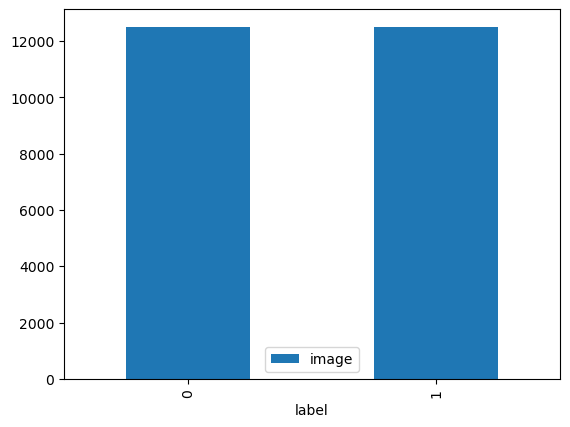

In [9]:
data.groupby("label").count().plot(kind="bar")

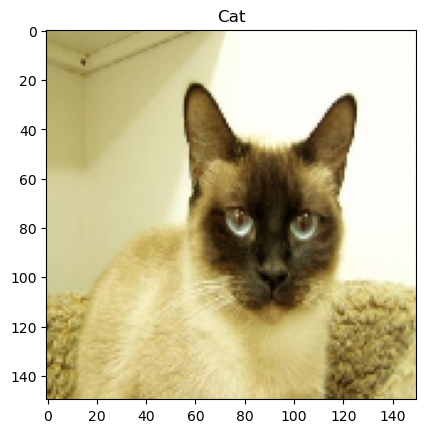

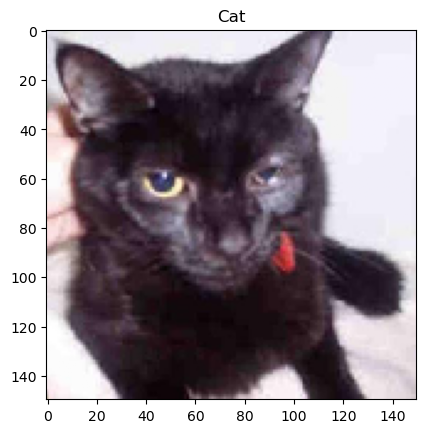

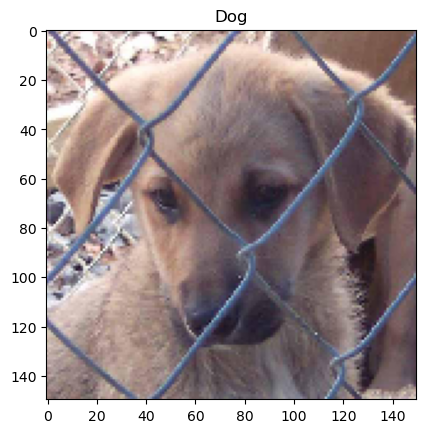

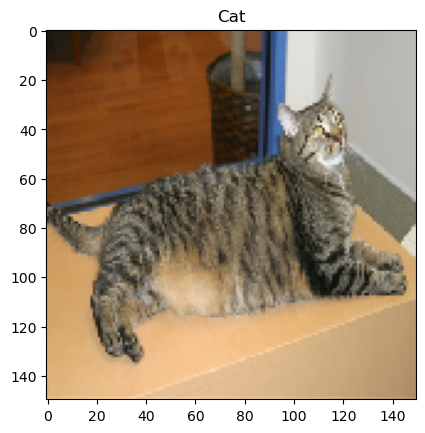

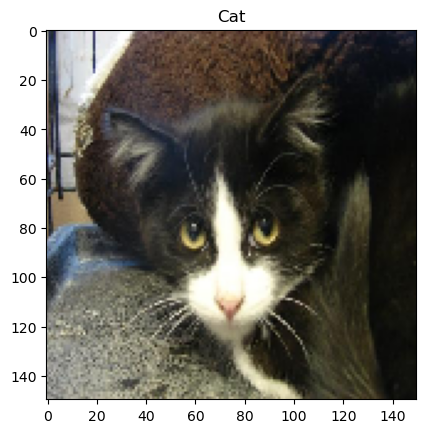

In [10]:
for i in range(5):
    plt.title(categories[animals[i][1]])
    plt.imshow(X[i]/255)
    plt.show()

In [11]:
X = np.array(X)
Y = np.array(y)

In [12]:
X = X/255

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19998, 150, 150, 3), (5000, 150, 150, 3), (19998, 2), (5000, 2))

## Data Augmentation

In [15]:
data_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

data_aug.fit(X_train)
augmented_data = data_aug.flow(X_train, y_train, batch_size=32)

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

2024-02-20 12:28:12.813355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 12:28:12.813446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [19]:
model.fit(augmented_data, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


2024-02-20 12:28:14.002242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-20 12:28:14.565891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 12:28:14.647648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


625/625 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.5436

2024-02-20 12:29:52.094103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 101s 153ms/step - loss: 0.7081 - accuracy: 0.5436 - val_loss: 0.6815 - val_accuracy: 0.5718
Epoch 2/10
625/625 [==============================] - 95s 152ms/step - loss: 0.6852 - accuracy: 0.5621 - val_loss: 0.6754 - val_accuracy: 0.5728
Epoch 3/10
625/625 [==============================] - 94s 150ms/step - loss: 0.6768 - accuracy: 0.5939 - val_loss: 0.6506 - val_accuracy: 0.6164
Epoch 4/10
625/625 [==============================] - 95s 152ms/step - loss: 0.6821 - accuracy: 0.6039 - val_loss: 0.6215 - val_accuracy: 0.6592
Epoch 5/10
625/625 [==============================] - 95s 152ms/step - loss: 0.7088 - accuracy: 0.6133 - val_loss: 0.6376 - val_accuracy: 0.6596
Epoch 6/10
625/625 [==============================] - 107s 170ms/step - loss: 0.7205 - accuracy: 0.6252 - val_loss: 0.6207 - val_accuracy: 0.6944
Epoch 7/10
625/625 [==============================] - 133s 212ms/step - loss: 0.8144 - accuracy: 0.6212 - val_loss: 0.7322 - val_accuracy: 

In [20]:
model.save("cats_and_dogs_model.h5")

In [21]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 4s 28ms/step - loss: 1.5076 - accuracy: 0.6504


[1.5075745582580566, 0.6503999829292297]

# Feature Map Visualization

1.0
  5/157 [..............................] - ETA: 2s 

2024-02-20 12:46:25.688034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 3s 19ms/step
(5000, 74, 74, 32)
(5000, 72, 72, 64)
(5000, 36, 36, 64)
(5000, 34, 34, 128)
(5000, 17, 17, 128)
(5000, 36992)
(5000, 512)
(5000, 512)
(5000, 2)


/var/folders/7n/498x98q54bbb5n96tdgsbc8h0000gn/T/ipykernel_23370/2924705434.py:22: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


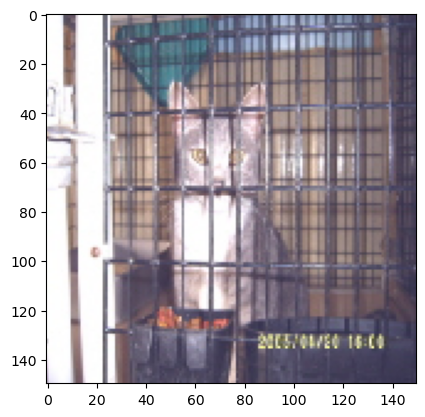

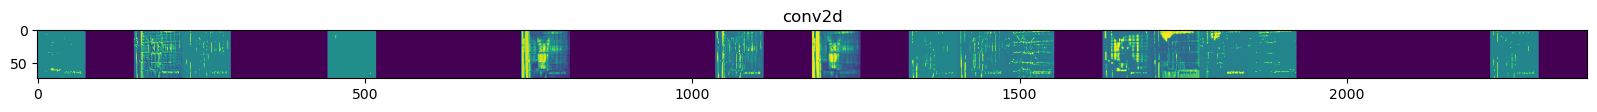

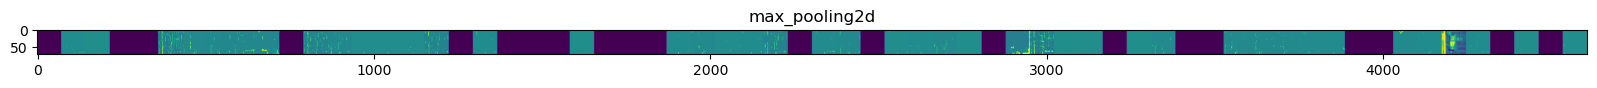

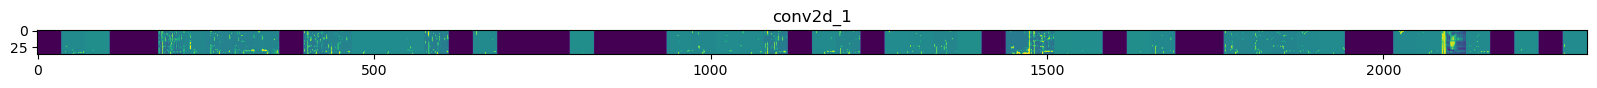

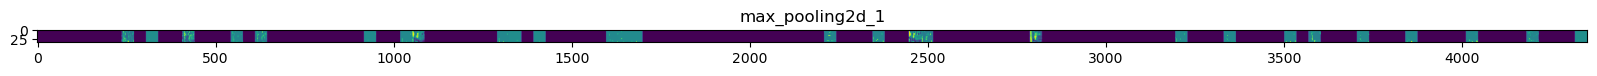

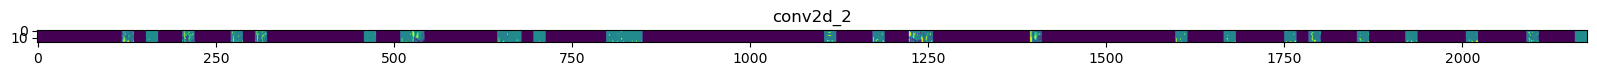

In [22]:
indix = 34

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

print(y_test[indix][0])

successive_feature_maps = visualization_model.predict(X_test)
layer_names = [layer.name for layer in model.layers]

plt.imshow(X_test[indix])

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[indix, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

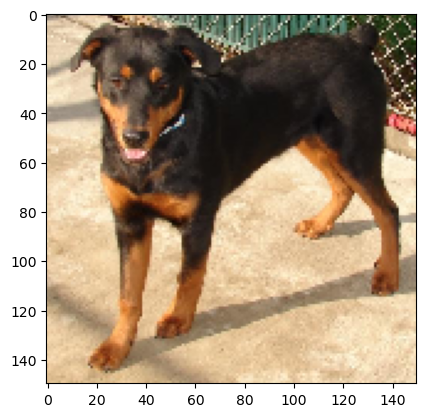

2024-02-20 12:46:53.069498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Dog
Dog


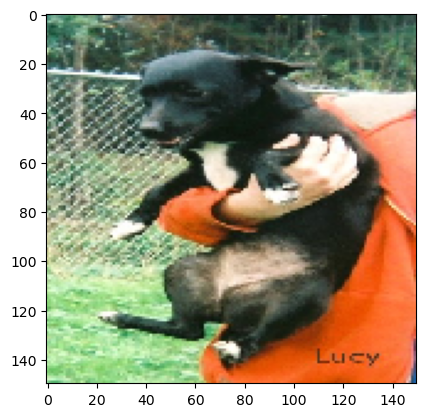

1/1 [==============================] - 0s 45ms/step
Dog
Dog


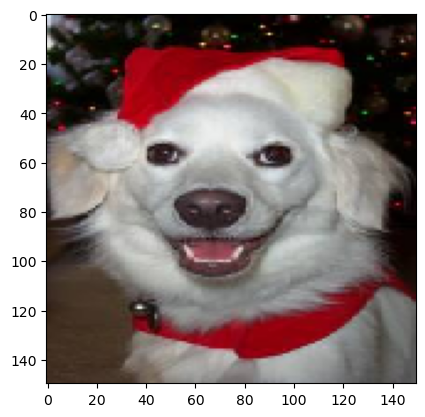

1/1 [==============================] - 0s 38ms/step
Cat
Dog


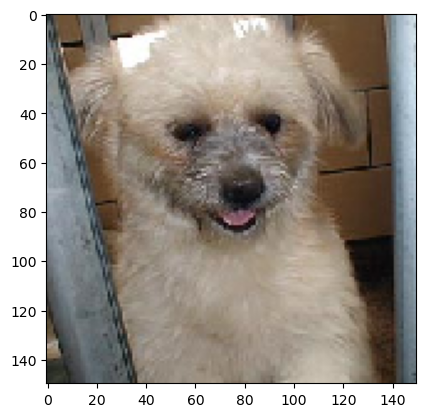

1/1 [==============================] - 0s 37ms/step
Cat
Dog


In [23]:
for i in range(4):
    indi = random.randint(0, len(X_test))
    plt.imshow(X_test[indi])
    plt.show()
    pred = model.predict(X_test[indi].reshape(1,150,150,3)).argmax()
    print(categories[pred])
    print(categories[y_test[indi].argmax()])